In [1]:
!head ../fish_trophic_positions.csv

"Taxon","TrophicPosition"
"Lepomis",3.34999990463257
"Lepomis gibbosus",3.25
"Perca flavescens",3.67000007629395
"Micropterus salmoides",3.83999991416931
"Salvelinus fontinalis",3.30999994277954
"Catostomus commersonii",2.8199999332428
"Semotilus atromaculatus",4.01999998092651
"Umbra limi",3.67000007629395
"Notemigonus crysoleucas",2.65000009536743


In [1]:
%%bash
cat ../download_blast_db.sh
sbatch ../download_blast_db.sh

#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks=20
#SBATCH --mem=256GB
#SBATCH --time=48:00:00
#SBATCH --job-name=updatebla

source ~/.bashrc
mkdir -p ~/scratch/db
conda activate assembly
cd ~/scratch/db

update_blastdb.pl --decompress core_nt --num_threads 20
Submitted batch job 24228370


core_nt downloaded from NCBI on 10/17/24 at 5:29PM EST. Database generated by NCBI on 2024-10-09 08:48. accession2taxid and taxdump downloaded from NCBI 10/17/24 at 6:43PM EST https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/nucl_gb.accession2taxid.gz generated by NCBI at 2024-10-12 04:23. 

The mussel blast searches get a fair amount of nonspecific hits, so we will perform a reduced search using Bivalvia GI numbers (search for GI numbers performed 11/1/2024 at 4:24PM EST):

In [207]:
%%bash
source ~/.bashrc
conda activate assembly
cd /scratch/nsl5160/db
blastdb_aliastool -gilist /storage/group/ibb3/default/acro_popgen_variants/trout_mitoassembly/bivalve.gi \
    -db /scratch/nsl5160/db/core_nt -dbtype nucl \
    -out core_nt_mussels -title core_nt_mussels

Converted 80765 GIs from /storage/group/ibb3/default/acro_popgen_variants/trout_mitoassembly/bivalve.gi to binary format in core_nt_mussels.n.gil
Created nucleotide BLAST (alias) database core_nt_mussels with 50391 sequences


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
asvs = pd.read_csv("../dada2_asv_table.csv")

In [59]:
!rm ../dada2_asvs.fasta

In [60]:
with open('../dada2_asvs.fasta', 'w') as f:
    for line in range(len(asvs)):
        f.write(">" + str(asvs["Unnamed: 0"][line]) + "\n")
        f.write(asvs["ASV"][line] + "\n")

In [61]:
!rm ../dada2_asvs_core_nt.out

In [62]:
%%bash
cat ../blast_asvs.sh
sbatch ../blast_asvs.sh

#!/bin/bash
#SBATCH --partition=open
#SBATCH --nodes=1
#SBATCH --ntasks=20
#SBATCH --mem=256GB
#SBATCH --time=48:00:00
#SBATCH --job-name=blastn

source ~/.bashrc
conda activate assembly

cd /storage/group/ibb3/default/acro_popgen_variants/trout_mitoassembly/

blastn -query ./dada2_asvs.fasta \
    -db /scratch/nsl5160/db/core_nt \
    -outfmt "6 qseqid staxids bitscore std" \
    -max_target_seqs 100 -max_hsps 100 \
    -num_threads 20 \
    -evalue 1e-25 \
    -out ./dada2_asvs_core_nt.out
Submitted batch job 25625441


In [207]:
hits = pd.read_csv("../dada2_asvs_core_nt.out", sep = "\t", header = None)

In [208]:
hits[1] = hits[1].str.split(";", expand = True)[0]

In [209]:
taxonomy = pd.read_csv("~/scratch/db/ncbi_lineages_2024-10-17.csv.gz", compression = "gzip")

In [210]:
taxonomy = taxonomy[['tax_id', 'superkingdom', 'phylum', 
                     'class', 'order', 'family', 'genus', 'species']]

In [211]:
hits.columns = [0, "tax_id", 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [212]:
hits["tax_id"] = hits["tax_id"].astype(int)

In [213]:
hits = hits.merge(taxonomy, how = "left", on = "tax_id")

In [214]:
hits[5] = hits[5].astype(float)

In [215]:
hits = hits[~hits["tax_id"].isin([2557536,8034,2972643,157020,59296,85566,225060,225392])].reset_index(drop=True)

In [216]:
hits["species"] = hits["species"].fillna("None")

In [217]:
hits = hits[~hits["species"].str.contains("sp\.")].reset_index(drop=True)

In [218]:
hits = hits[hits["superkingdom"].notna()].reset_index(drop=True)

In [219]:
for i in hits[0][hits["species"] == "Micropterus salmoides"].unique().tolist():
    print(hits[hits[0] == i].drop_duplicates(["species", 13]).head(10))

     0  tax_id    2  3            4       5    6  7  8   9  ...   11   12  \
395  5   27706  287  5   OM736837.1  98.758  161  2  0   9  ...  325  485   
412  5   27706  281  5  NC_008106.1  98.137  161  3  0   9  ...  325  485   
414  5   27706  276  5   OR380104.1  97.516  161  4  0   9  ...    9  169   
415  5   27706  274  5   OQ681498.1  98.701  154  2  0  16  ...    1  154   
417  5  225391  270  5   MH301072.1  96.894  161  5  0   9  ...  325  485   
418  5   27706  270  5   PP118449.1  96.894  161  5  0   9  ...  237  397   
423  5  147949  254  5   MF621711.1  95.031  161  8  0   9  ...  325  485   
428  5  147949  252  5   OK583901.1  95.000  160  8  0  10  ...  326  485   
430  5  147949  248  5   LC777187.1  94.410  161  9  0   9  ...  196  356   
436  5  147949  235  5   KM282429.1  94.156  154  9  0  16  ...    1  154   

               13  superkingdom    phylum        class             order  \
395  3.360000e-73     Eukaryota  Chordata  Actinopteri  Centrarchiformes   


         0  tax_id    2    3            4       5    6   7  8   9  ...   11  \
17745  202   27706  283  202   OM736837.1  98.742  159   2  0  11  ...  327   
17762  202   27706  278  202  NC_008106.1  98.113  159   3  0  11  ...  327   
17764  202   27706  274  202   OQ681498.1  98.701  154   2  0  16  ...    1   
17766  202   27706  272  202   OR380104.1  97.484  159   4  0  11  ...   11   
17767  202  225391  267  202   MH301072.1  96.855  159   5  0  11  ...  327   
17768  202   27706  267  202   PP118449.1  96.855  159   5  0  11  ...  239   
17773  202  147949  250  202   MF621711.1  94.969  159   8  0  11  ...  327   
17780  202  147949  244  202   LC777187.1  94.340  159   9  0  11  ...  198   
17786  202  147949  235  202   KM282429.1  94.156  154   9  0  16  ...    1   
17787  202    8182  222  202   OQ793720.1  91.824  159  13  0  11  ...  259   

        12            13  superkingdom    phylum        class  \
17745  485  4.350000e-72     Eukaryota  Chordata  Actinopteri   


         0  tax_id    2    3            4       5    6   7  8   9  ...    11  \
43500  501  147949  292  501   MF621711.1  98.780  164   2  0   6  ...   322   
43505  501  147949  289  501   OK583901.1  99.371  159   1  0  11  ...   327   
43507  501  147949  287  501   LC777187.1  98.171  164   3  0   6  ...   193   
43513  501  147949  274  501   KM282429.1  98.701  154   2  0  16  ...     1   
43514  501   27706  265  501  NC_008106.1  95.732  164   7  0   6  ...   322   
43516  501   27706  259  501   OM736837.1  95.122  164   8  0   6  ...   322   
43534  501  225391  254  501   MH301072.1  94.512  164   9  0   6  ...   322   
43535  501   27706  254  501   PP118449.1  94.512  164   9  0   6  ...   234   
43540  501   27706  246  501   OQ681498.1  95.455  154   7  0  16  ...     1   
43542  501  334880  222  501   KC136482.1  91.358  162  14  0   6  ...  1754   

         12            13  superkingdom    phylum        class  \
43500   485  7.230000e-75     Eukaryota  Chordata  Ac

         0  tax_id    2    3            4       5    6   7  8   9  ...   11  \
66865  767   13106  287  767   OQ793722.1  98.758  161   2  0   6  ...  254   
66869  767   13106  281  767   LC729859.1  98.137  161   3  0   6  ...    6   
66874  767  201691  281  767   OL457399.1  98.137  161   3  0   6  ...  322   
66893  767   13106  276  767   OQ198784.1  97.516  161   4  0   6  ...   27   
66898  767   13106  268  767   KM282426.1  98.675  151   2  0  16  ...    1   
66899  767   13106  254  767   MW630143.1  95.031  161   8  0   6  ...  253   
66900  767  255468  243  767  NC_084074.1  94.304  158   9  0   6  ...  322   
66901  767  255468  231  767   AY372810.1  93.082  159  10  1   6  ...  255   
66902  767  270333  226  767  NC_084075.1  91.975  162  12  1   6  ...  322   
66903  767  201691  215  767   OK623677.1  90.741  162  14  1   6  ...  322   

        12            13  superkingdom    phylum        class  \
66865  414  3.290000e-73     Eukaryota  Chordata  Actinopteri   


          0  tax_id    2     3            4       5    6   7  8   9  ...   11  \
86444  1003   27706  302  1003   OM736837.1  98.817  169   2  0   1  ...  317   
86461  1003   27706  296  1003  NC_008106.1  98.225  169   3  0   1  ...  317   
86463  1003   27706  291  1003   OR380104.1  97.633  169   4  0   1  ...    1   
86464  1003  225391  285  1003   MH301072.1  97.041  169   5  0   1  ...  317   
86465  1003   27706  285  1003   PP118449.1  97.041  169   5  0   1  ...  229   
86472  1003  147949  268  1003   MF621711.1  95.266  169   8  0   1  ...  317   
86477  1003  147949  263  1003   LC777187.1  94.675  169   9  0   1  ...  188   
86485  1003  147949  246  1003   KM282429.1  95.455  154   7  0  16  ...    1   
86486  1003    8182  241  1003   OQ793720.1  92.308  169  13  0   1  ...  249   
86487  1003   27706  241  1003   AH013021.2  97.842  139   3  0   1  ...  118   

        12            13  superkingdom    phylum        class  \
86444  485  1.200000e-77     Eukaryota  Cho

           0  tax_id    2     3            4       5    6  7  8   9  ...  \
108987  1262  109273  279  1262   OM736897.1  98.125  160  3  0   9  ...   
108995  1262  109273  268  1262   KM282394.1  98.052  154  3  0  15  ...   
108996  1262  201695  259  1262   OR380667.1  96.226  159  4  2   9  ...   
108997  1262  201695  254  1262   OR380666.1  95.597  159  5  2   9  ...   
108998  1262  201696  254  1262   OR379551.1  95.597  159  5  2   9  ...   
108999  1262    8182  248  1262   OQ793720.1  94.937  158  8  0   9  ...   
109000  1262  201694  248  1262  NC_084076.1  94.937  158  8  0   9  ...   
109003  1262  201696  248  1262   OP161456.1  94.969  159  6  2   9  ...   
109005  1262  270327  248  1262   OR551995.1  98.571  140  2  0  29  ...   
109006  1262  201701  243  1262   OQ793749.1  94.839  155  8  0   9  ...   

          11    12            13  superkingdom    phylum        class  \
108987  1288  1447  5.580000e-71     Eukaryota  Chordata  Actinopteri   
108995     1   15

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
133253  1550  147949  302  1550   MF621711.1  98.817  169   2  0   1  ...   
133258  1550  147949  296  1550   LC777187.1  98.225  169   3  0   1  ...   
133266  1550   27706  274  1550  NC_008106.1  95.858  169   7  0   1  ...   
133268  1550  147949  274  1550   KM282429.1  98.701  154   2  0  16  ...   
133269  1550   27706  268  1550   OM736837.1  95.266  169   8  0   1  ...   
133287  1550  225391  263  1550   MH301072.1  94.675  169   9  0   1  ...   
133288  1550   27706  263  1550   PP118449.1  94.675  169   9  0   1  ...   
133293  1550   27706  246  1550   OQ681498.1  95.455  154   7  0  16  ...   
133295  1550  334880  231  1550   KC136482.1  91.617  167  14  0   1  ...   
133296  1550  201699  231  1550   OR380578.1  91.617  167  14  0   1  ...   

          11    12            13  superkingdom    phylum        class  \
133253   317   485  1.200000e-77     Eukaryota  Chordata  Actinopteri   
133258

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
151521  1763  147949  296  1763   MF621711.1  98.225  169   3  0   1  ...   
151526  1763  147949  291  1763   LC777187.1  97.633  169   4  0   1  ...   
151534  1763   27706  268  1763  NC_008106.1  95.266  169   8  0   1  ...   
151536  1763  147949  268  1763   KM282429.1  98.052  154   3  0  16  ...   
151537  1763   27706  263  1763   OM736837.1  94.675  169   9  0   1  ...   
151555  1763  225391  257  1763   MH301072.1  94.083  169  10  0   1  ...   
151556  1763   27706  257  1763   PP118449.1  94.083  169  10  0   1  ...   
151561  1763   27706  241  1763   OQ681498.1  94.805  154   8  0  16  ...   
151563  1763  334880  226  1763   KC136482.1  91.018  167  15  0   1  ...   
151564  1763  201699  226  1763   OR380578.1  91.018  167  15  0   1  ...   

          11    12            13  superkingdom    phylum        class  \
151521   317   485  5.590000e-76     Eukaryota  Chordata  Actinopteri   
151526

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
174655  2023   27706  291  2023   OM736837.1  98.193  166   3  0   4  ...   
174672  2023   27706  285  2023  NC_008106.1  97.590  166   4  0   4  ...   
174674  2023   27706  279  2023   OR380104.1  96.988  166   5  0   4  ...   
174677  2023  225391  274  2023   MH301072.1  96.386  166   6  0   4  ...   
174678  2023   27706  274  2023   PP118449.1  96.386  166   6  0   4  ...   
174683  2023  147949  257  2023   MF621711.1  94.578  166   9  0   4  ...   
174690  2023  147949  252  2023   LC777187.1  93.976  166  10  0   4  ...   
174696  2023  147949  241  2023   KM282429.1  94.805  154   8  0  16  ...   
174697  2023    8182  230  2023   OQ793720.1  91.566  166  14  0   4  ...   
174698  2023   27706  230  2023   AH013021.2  97.059  136   4  0   4  ...   

         11   12            13  superkingdom    phylum        class  \
174655  320  485  2.600000e-74     Eukaryota  Chordata  Actinopteri   
174672  32

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
201051  2336   27706  278  2336   OM736837.1  98.718  156   2  0  14  ...   
201068  2336   27706  274  2336   OQ681498.1  98.701  154   2  0  16  ...   
201070  2336   27706  272  2336  NC_008106.1  98.077  156   3  0  14  ...   
201072  2336   27706  267  2336   OR380104.1  97.436  156   4  0  14  ...   
201073  2336  225391  261  2336   MH301072.1  96.795  156   5  0  14  ...   
201074  2336   27706  261  2336   PP118449.1  96.795  156   5  0  14  ...   
201079  2336  147949  244  2336   MF621711.1  94.872  156   8  0  14  ...   
201086  2336  147949  239  2336   LC777187.1  94.231  156   9  0  14  ...   
201092  2336  147949  235  2336   KM282429.1  94.156  154   9  0  16  ...   
201093  2336    8182  217  2336   OQ793720.1  91.667  156  13  0  14  ...   

         11   12            13  superkingdom    phylum        class  \
201051  330  485  2.020000e-70     Eukaryota  Chordata  Actinopteri   
201068    

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
226357  2630   27706  283  2630   OM736837.1  98.148  162   3  0   8  ...   
226374  2630   27706  278  2630  NC_008106.1  97.531  162   4  0   8  ...   
226376  2630   27706  272  2630   OR380104.1  96.914  162   5  0   8  ...   
226377  2630   27706  268  2630   OQ681498.1  98.052  154   3  0  16  ...   
226379  2630  225391  267  2630   MH301072.1  96.296  162   6  0   8  ...   
226380  2630   27706  267  2630   PP118449.1  96.296  162   6  0   8  ...   
226385  2630  147949  250  2630   MF621711.1  94.444  162   9  0   8  ...   
226390  2630  147949  246  2630   OK583901.1  94.375  160   9  0  10  ...   
226392  2630  147949  244  2630   LC777187.1  93.827  162  10  0   8  ...   
226398  2630  147949  230  2630   KM282429.1  93.506  154  10  0  16  ...   

         11   12            13  superkingdom    phylum        class  \
226357  324  485  4.350000e-72     Eukaryota  Chordata  Actinopteri   
226374  32

           0  tax_id    2     3            4       5    6  7  8   9  ...  \
237815  2762  109273  289  2762   OM736897.1  98.182  165  3  0   5  ...   
237823  2762  109273  279  2762   KM282394.1  99.351  154  1  0  16  ...   
237824  2762  201695  268  2762   OR380667.1  96.341  164  4  2   5  ...   
237825  2762  201695  263  2762   OR380666.1  95.732  164  5  2   5  ...   
237826  2762  201696  263  2762   OR379551.1  95.732  164  5  2   5  ...   
237827  2762    8182  257  2762   OQ793720.1  95.092  163  8  0   5  ...   
237828  2762  201694  257  2762  NC_084076.1  95.092  163  8  0   5  ...   
237831  2762  201696  257  2762   OP161456.1  95.122  164  6  2   5  ...   
237833  2762  270327  254  2762   OR551995.1  99.286  140  1  0  30  ...   
237834  2762  201701  252  2762   OQ793749.1  95.000  160  8  0   5  ...   

          11    12            13  superkingdom    phylum        class  \
237815  1283  1447  9.350000e-74     Eukaryota  Chordata  Actinopteri   
237823     1   15

           0  tax_id    2     3            4       5    6  7  8   9  ...  \
262492  3043  109273  285  3043   OM736897.1  98.750  160  2  0  10  ...   
262500  3043  109273  279  3043   KM282394.1  99.351  154  1  0  16  ...   
262501  3043  201695  265  3043   OR380667.1  96.855  159  3  2  10  ...   
262502  3043  201695  259  3043   OR380666.1  96.226  159  4  2  10  ...   
262503  3043  201696  259  3043   OR379551.1  96.226  159  4  2  10  ...   
262504  3043    8182  254  3043   OQ793720.1  95.570  158  7  0  10  ...   
262505  3043  201694  254  3043  NC_084076.1  95.570  158  7  0  10  ...   
262508  3043  201696  254  3043   OP161456.1  95.597  159  5  2  10  ...   
262510  3043  270327  254  3043   OR551995.1  99.286  140  1  0  30  ...   
262511  3043  201701  248  3043   OQ793749.1  95.484  155  7  0  10  ...   

          11    12            13  superkingdom    phylum        class  \
262492  1288  1447  1.210000e-72     Eukaryota  Chordata  Actinopteri   
262500     1   15

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
276519  3209  147949  285  3209   MF621711.1  98.750  160   2  0  10  ...   
276526  3209  147949  279  3209   LC777187.1  98.125  160   3  0  10  ...   
276532  3209  147949  274  3209   KM282429.1  98.701  154   2  0  16  ...   
276533  3209   27706  257  3209  NC_008106.1  95.625  160   7  0  10  ...   
276535  3209   27706  252  3209   OM736837.1  95.000  160   8  0  10  ...   
276553  3209  225391  246  3209   MH301072.1  94.375  160   9  0  10  ...   
276554  3209   27706  246  3209   PP118449.1  94.375  160   9  0  10  ...   
276561  3209  334880  215  3209   KC136482.1  91.139  158  14  0  10  ...   
276562  3209  201699  215  3209   OR380578.1  91.139  158  14  0  10  ...   
276563  3209  270327  215  3209   KM370985.1  91.139  158  14  0  10  ...   

          11    12            13  superkingdom    phylum        class  \
276519   326   485  1.210000e-72     Eukaryota  Chordata  Actinopteri   
276526

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
299875  3467   27706  281  3467   OM736837.1  98.137  161   3  0   9  ...   
299892  3467   27706  276  3467  NC_008106.1  97.516  161   4  0   9  ...   
299894  3467   27706  270  3467   OR380104.1  96.894  161   5  0   9  ...   
299895  3467   27706  268  3467   OQ681498.1  98.052  154   3  0  16  ...   
299897  3467  225391  265  3467   MH301072.1  96.273  161   6  0   9  ...   
299898  3467   27706  265  3467   PP118449.1  96.273  161   6  0   9  ...   
299903  3467  147949  248  3467   MF621711.1  94.410  161   9  0   9  ...   
299908  3467  147949  246  3467   OK583901.1  94.375  160   9  0  10  ...   
299910  3467  147949  243  3467   LC777187.1  93.789  161  10  0   9  ...   
299916  3467  147949  230  3467   KM282429.1  93.506  154  10  0  16  ...   

         11   12            13  superkingdom    phylum        class  \
299875  325  485  1.560000e-71     Eukaryota  Chordata  Actinopteri   
299892  32

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
320583  3705  109273  268  3705   OM736897.1  96.875  160   5  0   9  ...   
320591  3705  109273  257  3705   KM282394.1  96.753  154   5  0  15  ...   
320592  3705  201695  248  3705   OR380667.1  94.969  159   6  2   9  ...   
320593  3705  201695  243  3705   OR380666.1  94.340  159   7  2   9  ...   
320594  3705  201696  243  3705   OR379551.1  94.340  159   7  2   9  ...   
320595  3705    8182  237  3705   OQ793720.1  93.671  158  10  0   9  ...   
320596  3705  201694  237  3705  NC_084076.1  93.671  158  10  0   9  ...   
320599  3705  201696  237  3705   OP161456.1  93.711  159   8  2   9  ...   
320601  3705  270327  237  3705   OR551995.1  97.143  140   4  0  29  ...   
320602  3705  201701  231  3705   OQ793749.1  93.548  155  10  0   9  ...   

          11    12            13  superkingdom    phylum        class  \
320583  1288  1447  1.210000e-67     Eukaryota  Chordata  Actinopteri   
320591

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
337546  3905  147949  279  3905   MF621711.1  96.988  166   5  0   4  ...   
337553  3905  147949  274  3905   LC777187.1  96.386  166   6  0   4  ...   
337559  3905  147949  268  3905   KM282429.1  98.052  154   3  0  16  ...   
337560  3905   27706  252  3905  NC_008106.1  93.976  166  10  0   4  ...   
337562  3905   27706  246  3905   OM736837.1  93.373  166  11  0   4  ...   
337580  3905  225391  241  3905   MH301072.1  92.771  166  12  0   4  ...   
337581  3905   27706  241  3905   PP118449.1  92.771  166  12  0   4  ...   
337588  3905  334880  209  3905   KC136482.1  89.634  164  17  0   4  ...   
337589  3905  201699  209  3905   OR380578.1  89.634  164  17  0   4  ...   
337590  3905  270327  209  3905   KM370985.1  89.634  164  17  0   4  ...   

          11    12            13  superkingdom    phylum        class  \
337546   320   485  5.630000e-71     Eukaryota  Chordata  Actinopteri   
337553

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
363911  4199  147949  268  4199   MF621711.1  96.875  160   5  0   9  ...   
363918  4199  147949  263  4199   LC777187.1  96.250  160   6  0   9  ...   
363924  4199  147949  252  4199   KM282429.1  96.104  154   6  0  15  ...   
363925  4199   27706  241  4199  NC_008106.1  93.750  160  10  0   9  ...   
363927  4199   27706  235  4199   OM736837.1  93.125  160  11  0   9  ...   
363945  4199  225391  230  4199   MH301072.1  92.500  160  12  0   9  ...   
363946  4199   27706  230  4199   PP118449.1  92.500  160  12  0   9  ...   
363951  4199   27706  224  4199   OQ681498.1  92.857  154  11  0  15  ...   
363953  4199  334880  198  4199   KC136482.1  89.241  158  17  0   9  ...   
363954  4199  201699  198  4199   OR380578.1  89.241  158  17  0   9  ...   

          11    12            13  superkingdom    phylum        class  \
363911   326   485  1.210000e-67     Eukaryota  Chordata  Actinopteri   
363918

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
388818  4481  109273  279  4481   OM736897.1  96.450  169   6  0   1  ...   
388826  4481  109273  268  4481   KM282394.1  98.052  154   3  0  16  ...   
388827  4481  201695  259  4481   OR380667.1  94.643  168   7  2   1  ...   
388828  4481  201695  254  4481   OR380666.1  94.048  168   8  2   1  ...   
388829  4481  201696  254  4481   OR379551.1  94.048  168   8  2   1  ...   
388830  4481    8182  248  4481   OQ793720.1  93.413  167  11  0   1  ...   
388831  4481  201694  248  4481  NC_084076.1  93.413  167  11  0   1  ...   
388834  4481  201696  248  4481   OP161456.1  93.452  168   9  2   1  ...   
388836  4481  201701  243  4481   OQ793749.1  93.293  164  11  0   1  ...   
388839  4481  270327  243  4481   OR551995.1  97.857  140   3  0  30  ...   

          11    12            13  superkingdom    phylum        class  \
388818  1279  1447  5.630000e-71     Eukaryota  Chordata  Actinopteri   
388826

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
406676  4677   13106  278  4677   OQ793722.1  98.113  159   3  0   8  ...   
406680  4677   13106  272  4677   LC729859.1  97.484  159   4  0   8  ...   
406685  4677  201691  272  4677   OL457399.1  97.484  159   4  0   8  ...   
406704  4677   13106  267  4677   OQ198784.1  96.855  159   5  0   8  ...   
406709  4677   13106  263  4677   KM282426.1  98.013  151   3  0  16  ...   
406710  4677   13106  244  4677   MW630143.1  94.340  159   9  0   8  ...   
406711  4677  255468  233  4677  NC_084074.1  93.590  156  10  0   8  ...   
406712  4677  255468  222  4677   AY372810.1  92.357  157  11  1   8  ...   
406713  4677  270333  217  4677  NC_084075.1  91.250  160  13  1   8  ...   
406714  4677  201691  206  4677   OK623677.1  90.000  160  15  1   8  ...   

         11   12            13  superkingdom    phylum        class  \
406676  256  414  1.980000e-70     Eukaryota  Chordata  Actinopteri   
406680    

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
432756  4971   27706  278  4971   OM736837.1  98.113  159   3  0  11  ...   
432773  4971   27706  272  4971  NC_008106.1  97.484  159   4  0  11  ...   
432775  4971   27706  268  4971   OQ681498.1  98.052  154   3  0  16  ...   
432777  4971   27706  267  4971   OR380104.1  96.855  159   5  0  11  ...   
432778  4971  225391  261  4971   MH301072.1  96.226  159   6  0  11  ...   
432779  4971   27706  261  4971   PP118449.1  96.226  159   6  0  11  ...   
432784  4971  147949  244  4971   MF621711.1  94.340  159   9  0  11  ...   
432791  4971  147949  239  4971   LC777187.1  93.711  159  10  0  11  ...   
432797  4971  147949  230  4971   KM282429.1  93.506  154  10  0  16  ...   
432798  4971    8182  217  4971   OQ793720.1  91.195  159  14  0  11  ...   

         11   12            13  superkingdom    phylum        class  \
432756  327  485  2.020000e-70     Eukaryota  Chordata  Actinopteri   
432773  32

           0  tax_id    2     3            4        5    6  7  8   9  ...  \
455528  5223  109273  289  5223   OM736897.1  100.000  156  0  0  14  ...   
455536  5223  109273  285  5223   KM282394.1  100.000  154  0  0  16  ...   
455537  5223  201695  268  5223   OR380667.1   98.065  155  1  2  14  ...   
455538  5223  201695  263  5223   OR380666.1   97.419  155  2  2  14  ...   
455539  5223  201696  263  5223   OR379551.1   97.419  155  2  2  14  ...   
455540  5223  270327  259  5223   OR551995.1  100.000  140  0  0  30  ...   
455541  5223    8182  257  5223   OQ793720.1   96.753  154  5  0  14  ...   
455542  5223  201694  257  5223  NC_084076.1   96.753  154  5  0  14  ...   
455545  5223  201696  257  5223   OP161456.1   96.774  155  3  2  14  ...   
455547  5223  201701  252  5223   OQ793749.1   96.689  151  5  0  14  ...   

          11    12            13  superkingdom    phylum        class  \
455528  1292  1447  9.350000e-74     Eukaryota  Chordata  Actinopteri   
455536

           0  tax_id    2     3            4        5    6  7  8   9  ...  \
478839  5483  109273  296  5483   OM736897.1   98.795  166  2  0   4  ...   
478847  5483  109273  285  5483   KM282394.1  100.000  154  0  0  16  ...   
478848  5483  201695  276  5483   OR380667.1   96.970  165  3  2   4  ...   
478849  5483  201695  270  5483   OR380666.1   96.364  165  4  2   4  ...   
478850  5483  201696  270  5483   OR379551.1   96.364  165  4  2   4  ...   
478851  5483    8182  265  5483   OQ793720.1   95.732  164  7  0   4  ...   
478852  5483  201694  265  5483  NC_084076.1   95.732  164  7  0   4  ...   
478855  5483  201696  265  5483   OP161456.1   95.758  165  5  2   4  ...   
478857  5483  201701  259  5483   OQ793749.1   95.652  161  7  0   4  ...   
478860  5483  270327  259  5483   OR551995.1  100.000  140  0  0  30  ...   

          11    12            13  superkingdom    phylum        class  \
478839  1282  1447  5.590000e-76     Eukaryota  Chordata  Actinopteri   
478847

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
499960  5722   27706  281  5722   OM736837.1  97.561  164   4  0   6  ...   
499977  5722   27706  276  5722  NC_008106.1  96.951  164   5  0   6  ...   
499979  5722   27706  270  5722   OR380104.1  96.341  164   6  0   6  ...   
499980  5722   27706  268  5722   OQ681498.1  98.052  154   3  0  16  ...   
499982  5722  225391  265  5722   MH301072.1  95.732  164   7  0   6  ...   
499983  5722   27706  265  5722   PP118449.1  95.732  164   7  0   6  ...   
499988  5722  147949  248  5722   MF621711.1  93.902  164  10  0   6  ...   
499993  5722  147949  244  5722   OK583901.1  94.340  159   9  0  11  ...   
499995  5722  147949  243  5722   LC777187.1  93.293  164  11  0   6  ...   
500001  5722  147949  230  5722   KM282429.1  93.506  154  10  0  16  ...   

         11   12            13  superkingdom    phylum        class  \
499960  322  485  1.560000e-71     Eukaryota  Chordata  Actinopteri   
499977  32

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
525378  6017   27706  237  6017   OM736837.1  92.727  165  11  1   6  ...   
525395  6017   27706  231  6017  NC_008106.1  92.121  165  12  1   6  ...   
525397  6017   27706  226  6017   OR380104.1  91.515  165  13  1   6  ...   
525398  6017  225391  220  6017   MH301072.1  90.909  165  14  1   6  ...   
525399  6017   27706  220  6017   PP118449.1  90.909  165  14  1   6  ...   
525404  6017   27706  219  6017   OQ681498.1  92.258  155  11  1  16  ...   
525406  6017    8182  215  6017   OQ793720.1  90.303  165  15  1   6  ...   
525407  6017  147949  215  6017   MF621711.1  90.303  165  15  1   6  ...   
525420  6017    8167  213  6017   MH301080.1  90.625  160  15  0   6  ...   
525443  6017  109273  211  6017   OM736897.1  90.184  163  15  1   6  ...   

          11    12            13  superkingdom    phylum        class  \
525378   322   485  3.460000e-58     Eukaryota  Chordata  Actinopteri   
525395

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
548348  6276   27706  289  6276   OM736837.1  98.182  165   3  0   5  ...   
548365  6276   27706  283  6276  NC_008106.1  97.576  165   4  0   5  ...   
548367  6276   27706  278  6276   OR380104.1  96.970  165   5  0   5  ...   
548368  6276   27706  274  6276   OQ681498.1  98.701  154   2  0  16  ...   
548370  6276  225391  272  6276   MH301072.1  96.364  165   6  0   5  ...   
548371  6276   27706  272  6276   PP118449.1  96.364  165   6  0   5  ...   
548376  6276  147949  255  6276   MF621711.1  94.545  165   9  0   5  ...   
548381  6276  147949  252  6276   OK583901.1  95.000  160   8  0  10  ...   
548383  6276  147949  250  6276   LC777187.1  93.939  165  10  0   5  ...   
548389  6276  147949  235  6276   KM282429.1  94.156  154   9  0  16  ...   

         11   12            13  superkingdom    phylum        class  \
548348  321  485  9.350000e-74     Eukaryota  Chordata  Actinopteri   
548365  32

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
575638  6589   27706  261  6589   OM736837.1  96.226  159   6  0  11  ...   
575655  6589   27706  255  6589  NC_008106.1  95.597  159   7  0  11  ...   
575659  6589   27706  250  6589   OR380104.1  94.969  159   8  0  11  ...   
575660  6589  225391  244  6589   MH301072.1  94.340  159   9  0  11  ...   
575661  6589   27706  244  6589   PP118449.1  94.340  159   9  0  11  ...   
575666  6589  147949  228  6589   MF621711.1  92.453  159  12  0  11  ...   
575673  6589  147949  222  6589   LC777187.1  91.824  159  13  0  11  ...   
575679  6589  147949  217  6589   KM282429.1  93.197  147  10  0  23  ...   
575680  6589    8182  206  6589   OQ793720.1  89.937  159  16  0  11  ...   
575683  6589   27706  200  6589   AH013021.2  94.574  129   7  0  11  ...   

         11   12            13  superkingdom    phylum        class  \
575638  327  485  2.040000e-65     Eukaryota  Chordata  Actinopteri   
575655  32

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
603152  6923  147949  276  6923   MF621711.1  97.516  161   4  0   9  ...   
603157  6923  147949  274  6923   OK583901.1  97.500  160   4  0  10  ...   
603159  6923  147949  270  6923   LC777187.1  96.894  161   5  0   9  ...   
603165  6923  147949  257  6923   KM282429.1  96.753  154   5  0  16  ...   
603166  6923   27706  248  6923  NC_008106.1  94.410  161   9  0   9  ...   
603168  6923   27706  243  6923   OM736837.1  93.789  161  10  0   9  ...   
603186  6923  225391  237  6923   MH301072.1  93.168  161  11  0   9  ...   
603187  6923   27706  237  6923   PP118449.1  93.168  161  11  0   9  ...   
603192  6923   27706  230  6923   OQ681498.1  93.506  154  10  0  16  ...   
603194  6923   27706  209  6923   AH013021.2  95.420  131   6  0   9  ...   

         11   12            13  superkingdom    phylum        class  \
603152  325  485  7.280000e-70     Eukaryota  Chordata  Actinopteri   
603157  32

           0  tax_id    2     3            4       5    6  7  8   9  ...   11  \
630637  7247   27706  342  7247   OM736837.1  98.953  191  2  0   9  ...  325   
630652  7247   27706  337  7247  NC_008106.1  98.429  191  3  0   9  ...  325   
630654  7247   27706  329  7247   KM282430.1  98.913  184  2  0  16  ...    1   
630655  7247  225391  326  7247   MH301072.1  97.382  191  5  0   9  ...  325   
630656  7247   27706  326  7247   PP118449.1  97.382  191  5  0   9  ...  237   
630661  7247   27706  324  7247   OQ681498.1  98.895  181  2  0  16  ...    1   
630662  7247  147949  309  7247   MF621711.1  95.812  191  8  0   9  ...  325   
630666  7247  147949  307  7247   OK583901.1  95.789  190  8  0  10  ...  326   
630668  7247  147949  303  7247   LC777187.1  95.288  191  9  0   9  ...  196   
630672  7247  147949  291  7247   KM282429.1  95.109  184  9  0  16  ...    1   

         12            13  superkingdom    phylum        class  \
630637  515  9.220000e-90     Eukaryota  C

           0  tax_id    2     3            4       5    6   7  8   9  ...  \
645626  7412  109273  309  7412   OM736897.1  96.757  185   6  0  12  ...   
645633  7412  109273  302  7412   KM282394.1  96.685  181   6  0  16  ...   
645634  7412  270327  279  7412   OR551995.1  96.988  166   5  0  31  ...   
645635  7412    8182  276  7412   OQ793720.1  93.514  185  12  0  12  ...   
645636  7412  201694  276  7412  NC_084076.1  93.514  185  12  0  12  ...   
645639  7412  201697  270  7412   OQ198764.1  92.973  185  13  0  12  ...   
645644  7412  201701  270  7412   OQ793749.1  92.973  185  13  0  12  ...   
645651  7412  201701  265  7412   OQ793748.1  92.432  185  14  0  12  ...   
645653  7412  270327  265  7412   KM370985.1  92.432  185  14  0  12  ...   
645654  7412  201697  263  7412   OQ198756.1  92.432  185  13  1  12  ...   

          11    12            13  superkingdom    phylum        class  \
645626  1290  1474  8.930000e-80     Eukaryota  Chordata  Actinopteri   
645633

In [178]:
import warnings
warnings.simplefilter(action='ignore')

In [220]:
hitmatches = pd.DataFrame()
for asv in hits[0].unique():
    tmp = hits.loc[hits[0] == asv].reset_index(drop=True)
    refseq = tmp.loc[tmp[4].str.contains("^NC")][tmp[5] > 90].reset_index(drop=True)
    tmp = tmp.drop_duplicates([5, "species"]).reset_index(drop=True)
    refseq = refseq.drop_duplicates([5, "species"]).reset_index(drop=True)
    toprefseq = refseq.loc[refseq[5] == refseq[5].max()].reset_index(drop=True)
    topall = tmp.loc[tmp[5] == tmp[5].max()].reset_index(drop=True)
    try:
        species = topall.groupby(0)["species"].unique().agg(','.join).reset_index(drop=True)[0]
        genus = topall.groupby(0)["genus"].unique().agg(','.join).reset_index(drop=True)[0]
        family = topall.groupby(0)["family"].unique().agg(','.join).reset_index(drop=True)[0]
        order = topall.groupby(0)["order"].unique().agg(','.join).reset_index(drop=True)[0]
        classs = topall.groupby(0)["class"].unique().agg(','.join).reset_index(drop=True)[0]
        phylum = topall.groupby(0)["phylum"].unique().agg(','.join).reset_index(drop=True)[0]
        superkingdom = topall.groupby(0)["superkingdom"].unique().agg(','.join).reset_index(drop=True)[0]
        perc_id = topall[5][0]
        eval_all = topall[13][0]
    except:
        species = np.nan
        genus = np.nan
        family = np.nan
        order = np.nan
        classs = np.nan
        phylum = np.nan
        superkingdom = np.nan
        perc_id = np.nan
        eval_all = np.nan
    try:
        species_r = toprefseq.groupby(0)["species"].unique().agg(','.join).reset_index(drop=True)[0]
        genus_r = toprefseq.groupby(0)["genus"].unique().agg(','.join).reset_index(drop=True)[0]
        family_r = toprefseq.groupby(0)["family"].unique().agg(','.join).reset_index(drop=True)[0]
        order_r = toprefseq.groupby(0)["order"].unique().agg(','.join).reset_index(drop=True)[0]
        classs_r = toprefseq.groupby(0)["class"].unique().agg(','.join).reset_index(drop=True)[0]
        phylum_r = toprefseq.groupby(0)["phylum"].unique().agg(','.join).reset_index(drop=True)[0]
        superkingdom_r = toprefseq.groupby(0)["superkingdom"].unique().agg(','.join).reset_index(drop=True)[0]
        perc_id_r = toprefseq[5][0]
        eval_all_r = toprefseq[13][0]
    except:
        species_r = np.nan
        genus_r = np.nan
        family_r = np.nan
        order_r = np.nan
        classs_r = np.nan
        phylum_r = np.nan
        superkingdom_r = np.nan
        perc_id_r = np.nan
        eval_all_r = np.nan
    tmp = pd.DataFrame([[asv, 
               superkingdom, phylum, classs, order, family, genus, species, 
               perc_id, eval_all,
               superkingdom_r, phylum_r, classs_r, order_r, family_r, genus_r, species_r,
               perc_id_r, eval_all_r]])
    tmp.columns = (["Unnamed: 0", 
                    "Superkingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species", "Percent_ID", "evalue"] + 
                   ["Superkingdom_Refseq", "Phylum_Refseq", "Class_Refseq", "Order_Refseq", "Family_Refseq", "Genus_Refseq", "Species_Refseq", "Percent_ID_Refseq", "evalue_Refseq"])
    hitmatches = pd.concat([hitmatches, tmp]).reset_index(drop=True)

In [221]:
asvs = asvs.merge(hitmatches, how = "left", on = "Unnamed: 0").reset_index(drop=True)

In [222]:
asvs = asvs.fillna("NA")

In [223]:
asvs.loc[~asvs["Species"].str.contains(","), "Best_Hit"] = asvs["Species"]
asvs.loc[~asvs["Species"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Species"
asvs.loc[asvs["Species"].str.contains(","), "Best_Hit"] = asvs["Genus"]
asvs.loc[asvs["Species"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Genus"
asvs.loc[asvs["Genus"].str.contains(","), "Best_Hit"] = asvs["Family"]
asvs.loc[asvs["Genus"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Family"
asvs.loc[asvs["Family"].str.contains(","), "Best_Hit"] = asvs["Order"]
asvs.loc[asvs["Family"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Order"
asvs.loc[asvs["Order"].str.contains(","), "Best_Hit"] = asvs["Class"]
asvs.loc[asvs["Order"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Class"
asvs.loc[asvs["Class"].str.contains(","), "Best_Hit"] = asvs["Phylum"]
asvs.loc[asvs["Class"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Phylum"
asvs.loc[asvs["Phylum"].str.contains(","), "Best_Hit"] = asvs["Superkingdom"]
asvs.loc[asvs["Phylum"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Superkingdom"

In [224]:
asvs.loc[~asvs["Species_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Species_Refseq"]
asvs.loc[~asvs["Species_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Species"
asvs.loc[asvs["Species_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Genus_Refseq"]
asvs.loc[asvs["Species_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Genus"
asvs.loc[asvs["Genus_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Family_Refseq"]
asvs.loc[asvs["Genus_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Family"
asvs.loc[asvs["Family_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Order_Refseq"]
asvs.loc[asvs["Family_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Order"
asvs.loc[asvs["Order_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Class_Refseq"]
asvs.loc[asvs["Order_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Class"
asvs.loc[asvs["Class_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Phylum_Refseq"]
asvs.loc[asvs["Class_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Phylum"
asvs.loc[asvs["Phylum_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Superkingdom_Refseq"]
asvs.loc[asvs["Phylum_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Superkingdom"

In [225]:
asvs.to_csv("../dada2_asv_table_with_taxonomy.csv", index = False)

Now we process the insects (only Moss Lake):

In [73]:
asvs = pd.read_csv("../dada2_asv_table_insects.csv")

In [209]:
!rm ../dada2_asvs_insects.fasta

In [210]:
with open('../dada2_asvs_insects.fasta', 'w') as f:
    for line in range(len(asvs)):
        f.write(">" + str(asvs["Unnamed: 0"][line]) + "\n")
        f.write(asvs["ASV"][line] + "\n")

In [211]:
!rm ../dada2_asvs_core_nt_insects.out

In [212]:
%%bash
cat ../blast_asvs_insects.sh
sbatch ../blast_asvs_insects.sh

#!/bin/bash
#SBATCH --partition=open
#SBATCH --nodes=1
#SBATCH --ntasks=20
#SBATCH --mem=256GB
#SBATCH --time=48:00:00
#SBATCH --job-name=blastn

source ~/.bashrc
conda activate assembly

cd /storage/group/ibb3/default/acro_popgen_variants/trout_mitoassembly/

blastn -query ./dada2_asvs_insects.fasta \
    -db /scratch/nsl5160/db/core_nt \
    -outfmt "6 qseqid staxids bitscore std" \
    -max_target_seqs 100 -max_hsps 100 \
    -num_threads 20 \
    -evalue 1e-25 \
    -out ./dada2_asvs_core_nt_insects.out
Submitted batch job 25645356


In [74]:
hits = pd.read_csv("../dada2_asvs_core_nt_insects.out", sep = "\t", header = None)

In [75]:
hits[1] = hits[1].str.split(";", expand = True)[0]

In [76]:
taxonomy = pd.read_csv("~/scratch/db/ncbi_lineages_2024-10-17.csv.gz", compression = "gzip")

In [77]:
taxonomy = taxonomy[['tax_id', 'superkingdom', 'phylum', 
                     'class', 'order', 'family', 'genus', 'species']]

In [78]:
hits.columns = [0, "tax_id", 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [79]:
hits["tax_id"] = hits["tax_id"].astype(int)

In [80]:
hits = hits.merge(taxonomy, how = "left", on = "tax_id")

In [81]:
hits[5] = hits[5].astype(float)

In [82]:
hits["species"] = hits["species"].fillna("None")

In [83]:
hits["genus"] = hits["genus"].fillna("None")

In [84]:
hits = hits[hits["superkingdom"].notna()].reset_index(drop=True)

In [85]:
import warnings
warnings.simplefilter(action='ignore')

In [86]:
hitmatches = pd.DataFrame()
for asv in hits[0].unique():
    tmp = hits.loc[hits[0] == asv].reset_index(drop=True)
    refseq = tmp.loc[tmp[4].str.contains("^NC")][tmp[5] > 90].reset_index(drop=True)
    tmp = tmp.drop_duplicates([5, "species"]).reset_index(drop=True)
    refseq = refseq.drop_duplicates([5, "species"]).reset_index(drop=True)
    toprefseq = refseq.loc[refseq[5] == refseq[5].max()].reset_index(drop=True)
    topall = tmp.loc[tmp[5] == tmp[5].max()].reset_index(drop=True)
    try:
        species = topall.groupby(0)["species"].unique().agg(','.join).reset_index(drop=True)[0]
        genus = topall.groupby(0)["genus"].unique().agg(','.join).reset_index(drop=True)[0]
        family = topall.groupby(0)["family"].unique().agg(','.join).reset_index(drop=True)[0]
        order = topall.groupby(0)["order"].unique().agg(','.join).reset_index(drop=True)[0]
        classs = topall.groupby(0)["class"].unique().agg(','.join).reset_index(drop=True)[0]
        phylum = topall.groupby(0)["phylum"].unique().agg(','.join).reset_index(drop=True)[0]
        superkingdom = topall.groupby(0)["superkingdom"].unique().agg(','.join).reset_index(drop=True)[0]
        perc_id = topall[5][0]
        eval_all = topall[13][0]
    except:
        species = np.nan
        genus = np.nan
        family = np.nan
        order = np.nan
        classs = np.nan
        phylum = np.nan
        superkingdom = np.nan
        perc_id = np.nan
        eval_all = np.nan
    try:
        species_r = toprefseq.groupby(0)["species"].unique().agg(','.join).reset_index(drop=True)[0]
        genus_r = toprefseq.groupby(0)["genus"].unique().agg(','.join).reset_index(drop=True)[0]
        family_r = toprefseq.groupby(0)["family"].unique().agg(','.join).reset_index(drop=True)[0]
        order_r = toprefseq.groupby(0)["order"].unique().agg(','.join).reset_index(drop=True)[0]
        classs_r = toprefseq.groupby(0)["class"].unique().agg(','.join).reset_index(drop=True)[0]
        phylum_r = toprefseq.groupby(0)["phylum"].unique().agg(','.join).reset_index(drop=True)[0]
        superkingdom_r = toprefseq.groupby(0)["superkingdom"].unique().agg(','.join).reset_index(drop=True)[0]
        perc_id_r = toprefseq[5][0]
        eval_all_r = toprefseq[13][0]
    except:
        species_r = np.nan
        genus_r = np.nan
        family_r = np.nan
        order_r = np.nan
        classs_r = np.nan
        phylum_r = np.nan
        superkingdom_r = np.nan
        perc_id_r = np.nan
        eval_all_r = np.nan
    tmp = pd.DataFrame([[asv, 
               superkingdom, phylum, classs, order, family, genus, species, 
               perc_id, eval_all,
               superkingdom_r, phylum_r, classs_r, order_r, family_r, genus_r, species_r,
               perc_id_r, eval_all_r]])
    tmp.columns = (["Unnamed: 0", 
                    "Superkingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species", "Percent_ID", "evalue"] + 
                   ["Superkingdom_Refseq", "Phylum_Refseq", "Class_Refseq", "Order_Refseq", "Family_Refseq", "Genus_Refseq", "Species_Refseq", "Percent_ID_Refseq", "evalue_Refseq"])
    hitmatches = pd.concat([hitmatches, tmp]).reset_index(drop=True)

In [87]:
asvs = asvs.merge(hitmatches, how = "left", on = "Unnamed: 0").reset_index(drop=True)

In [88]:
asvs = asvs.fillna("NA")

In [89]:
asvs.loc[~asvs["Species"].str.contains(","), "Best_Hit"] = asvs["Species"]
asvs.loc[~asvs["Species"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Species"
asvs.loc[asvs["Species"].str.contains(","), "Best_Hit"] = asvs["Genus"]
asvs.loc[asvs["Species"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Genus"
asvs.loc[asvs["Genus"].str.contains(","), "Best_Hit"] = asvs["Family"]
asvs.loc[asvs["Genus"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Family"
asvs.loc[asvs["Family"].str.contains(","), "Best_Hit"] = asvs["Order"]
asvs.loc[asvs["Family"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Order"
asvs.loc[asvs["Order"].str.contains(","), "Best_Hit"] = asvs["Class"]
asvs.loc[asvs["Order"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Class"
asvs.loc[asvs["Class"].str.contains(","), "Best_Hit"] = asvs["Phylum"]
asvs.loc[asvs["Class"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Phylum"
asvs.loc[asvs["Phylum"].str.contains(","), "Best_Hit"] = asvs["Superkingdom"]
asvs.loc[asvs["Phylum"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Superkingdom"

In [90]:
asvs.loc[~asvs["Species_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Species_Refseq"]
asvs.loc[~asvs["Species_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Species"
asvs.loc[asvs["Species_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Genus_Refseq"]
asvs.loc[asvs["Species_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Genus"
asvs.loc[asvs["Genus_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Family_Refseq"]
asvs.loc[asvs["Genus_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Family"
asvs.loc[asvs["Family_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Order_Refseq"]
asvs.loc[asvs["Family_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Order"
asvs.loc[asvs["Order_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Class_Refseq"]
asvs.loc[asvs["Order_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Class"
asvs.loc[asvs["Class_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Phylum_Refseq"]
asvs.loc[asvs["Class_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Phylum"
asvs.loc[asvs["Phylum_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Superkingdom_Refseq"]
asvs.loc[asvs["Phylum_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Superkingdom"

In [91]:
asvs.to_csv("../dada2_insects_asv_table_with_taxonomy.csv", index = False)

Now we process the mussels (all lakes):

In [92]:
asvs = pd.read_csv("../dada2_asv_table_mussels.csv")

In [233]:
!rm ../dada2_asvs_mussels.fasta

In [234]:
with open('../dada2_asvs_mussels.fasta', 'w') as f:
    for line in range(len(asvs)):
        f.write(">" + str(asvs["Unnamed: 0"][line]) + "\n")
        f.write(asvs["ASV"][line] + "\n")

In [235]:
!rm ../dada2_asvs_core_nt_mussels.out

In [237]:
%%bash
cat ../blast_asvs_mussels.sh
sbatch ../blast_asvs_mussels.sh

#!/bin/bash
#SBATCH --partition=open
#SBATCH --nodes=1
#SBATCH --ntasks=20
#SBATCH --mem=256GB
#SBATCH --time=48:00:00
#SBATCH --job-name=blastn

source ~/.bashrc
conda activate assembly

cd /storage/group/ibb3/default/acro_popgen_variants/trout_mitoassembly/

blastn -query ./dada2_asvs_mussels.fasta \
    -db /scratch/nsl5160/db/core_nt_mussels \
    -outfmt "6 qseqid staxids bitscore std" \
    -max_target_seqs 100 -max_hsps 100 \
    -num_threads 20 \
    -evalue 1e-25 \
    -out ./dada2_asvs_core_nt_mussels.out
Submitted batch job 25685733


In [226]:
hits = pd.read_csv("../dada2_asvs_core_nt_mussels.out", sep = "\t", header = None)

In [227]:
hits[1] = hits[1].str.split(";", expand = True)[0]

In [228]:
taxonomy = pd.read_csv("~/scratch/db/ncbi_lineages_2024-10-17.csv.gz", compression = "gzip")

In [229]:
taxonomy = taxonomy[['tax_id', 'superkingdom', 'phylum', 
                     'class', 'order', 'family', 'genus', 'species']]

In [230]:
hits.columns = [0, "tax_id", 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [231]:
hits["tax_id"] = hits["tax_id"].astype(int)

In [232]:
hits = hits.merge(taxonomy, how = "left", on = "tax_id")

In [233]:
hits = hits[hits["class"] == "Bivalvia"].reset_index(drop=True)

In [234]:
hits[5] = hits[5].astype(float)

In [236]:
hits[hits[5] >95].value_counts("species")

species
Elliptio hopetonensis     795
Elliptio icterina         704
Elliptio complanata       701
Elliptio dariensis        439
Elliptio crassidens       428
Elliptio downiei          156
Elliptio mcmichaeli       156
Elliptio congaraea        147
Elliptio fumata           115
Elliptio arca              93
Elliptio pullata           77
Elliptio jayensis          39
Utterbackia imbecillis     24
Elliptio roanokensis       22
Elliptio arctata           15
Elliptio purpurella        10
Elliptio folliculata        3
dtype: int64

In [102]:
hits["species"] = hits["species"].fillna("None")

In [103]:
hits["genus"] = hits["genus"].fillna("None")

In [104]:
import warnings
warnings.simplefilter(action='ignore')

In [105]:
hitmatches = pd.DataFrame()
for asv in hits[0].unique():
    tmp = hits.loc[hits[0] == asv].reset_index(drop=True)
    refseq = tmp.loc[tmp[4].str.contains("^NC")][tmp[5] > 90].reset_index(drop=True)
    tmp = tmp.drop_duplicates([5, "species"]).reset_index(drop=True)
    refseq = refseq.drop_duplicates([5, "species"]).reset_index(drop=True)
    toprefseq = refseq.loc[refseq[5] == refseq[5].max()].reset_index(drop=True)
    topall = tmp.loc[tmp[5] == tmp[5].max()].reset_index(drop=True)
    try:
        species = topall.groupby(0)["species"].unique().agg(','.join).reset_index(drop=True)[0]
        genus = topall.groupby(0)["genus"].unique().agg(','.join).reset_index(drop=True)[0]
        family = topall.groupby(0)["family"].unique().agg(','.join).reset_index(drop=True)[0]
        order = topall.groupby(0)["order"].unique().agg(','.join).reset_index(drop=True)[0]
        classs = topall.groupby(0)["class"].unique().agg(','.join).reset_index(drop=True)[0]
        phylum = topall.groupby(0)["phylum"].unique().agg(','.join).reset_index(drop=True)[0]
        superkingdom = topall.groupby(0)["superkingdom"].unique().agg(','.join).reset_index(drop=True)[0]
        perc_id = topall[5][0]
        eval_all = topall[13][0]
    except:
        species = np.nan
        genus = np.nan
        family = np.nan
        order = np.nan
        classs = np.nan
        phylum = np.nan
        superkingdom = np.nan
        perc_id = np.nan
        eval_all = np.nan
    try:
        species_r = toprefseq.groupby(0)["species"].unique().agg(','.join).reset_index(drop=True)[0]
        genus_r = toprefseq.groupby(0)["genus"].unique().agg(','.join).reset_index(drop=True)[0]
        family_r = toprefseq.groupby(0)["family"].unique().agg(','.join).reset_index(drop=True)[0]
        order_r = toprefseq.groupby(0)["order"].unique().agg(','.join).reset_index(drop=True)[0]
        classs_r = toprefseq.groupby(0)["class"].unique().agg(','.join).reset_index(drop=True)[0]
        phylum_r = toprefseq.groupby(0)["phylum"].unique().agg(','.join).reset_index(drop=True)[0]
        superkingdom_r = toprefseq.groupby(0)["superkingdom"].unique().agg(','.join).reset_index(drop=True)[0]
        perc_id_r = toprefseq[5][0]
        eval_all_r = toprefseq[13][0]
    except:
        species_r = np.nan
        genus_r = np.nan
        family_r = np.nan
        order_r = np.nan
        classs_r = np.nan
        phylum_r = np.nan
        superkingdom_r = np.nan
        perc_id_r = np.nan
        eval_all_r = np.nan
    tmp = pd.DataFrame([[asv, 
               superkingdom, phylum, classs, order, family, genus, species, 
               perc_id, eval_all,
               superkingdom_r, phylum_r, classs_r, order_r, family_r, genus_r, species_r,
               perc_id_r, eval_all_r]])
    tmp.columns = (["Unnamed: 0", 
                    "Superkingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species", "Percent_ID", "evalue"] + 
                   ["Superkingdom_Refseq", "Phylum_Refseq", "Class_Refseq", "Order_Refseq", "Family_Refseq", "Genus_Refseq", "Species_Refseq", "Percent_ID_Refseq", "evalue_Refseq"])
    hitmatches = pd.concat([hitmatches, tmp]).reset_index(drop=True)

In [106]:
hitmatches = hitmatches[hitmatches["Percent_ID"] > 95]

In [107]:
asvs = asvs.merge(hitmatches, how = "left", on = "Unnamed: 0").reset_index(drop=True)

In [108]:
asvs = asvs.fillna("NA")

In [109]:
asvs.loc[~asvs["Species"].str.contains(","), "Best_Hit"] = asvs["Species"]
asvs.loc[~asvs["Species"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Species"
asvs.loc[asvs["Species"].str.contains(","), "Best_Hit"] = asvs["Genus"]
asvs.loc[asvs["Species"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Genus"
asvs.loc[asvs["Genus"].str.contains(","), "Best_Hit"] = asvs["Family"]
asvs.loc[asvs["Genus"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Family"
asvs.loc[asvs["Family"].str.contains(","), "Best_Hit"] = asvs["Order"]
asvs.loc[asvs["Family"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Order"
asvs.loc[asvs["Order"].str.contains(","), "Best_Hit"] = asvs["Class"]
asvs.loc[asvs["Order"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Class"
asvs.loc[asvs["Class"].str.contains(","), "Best_Hit"] = asvs["Phylum"]
asvs.loc[asvs["Class"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Phylum"
asvs.loc[asvs["Phylum"].str.contains(","), "Best_Hit"] = asvs["Superkingdom"]
asvs.loc[asvs["Phylum"].str.contains(","), "Best_Hit_Taxonomic_level"] = "Superkingdom"

In [110]:
asvs.loc[~asvs["Species_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Species_Refseq"]
asvs.loc[~asvs["Species_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Species"
asvs.loc[asvs["Species_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Genus_Refseq"]
asvs.loc[asvs["Species_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Genus"
asvs.loc[asvs["Genus_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Family_Refseq"]
asvs.loc[asvs["Genus_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Family"
asvs.loc[asvs["Family_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Order_Refseq"]
asvs.loc[asvs["Family_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Order"
asvs.loc[asvs["Order_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Class_Refseq"]
asvs.loc[asvs["Order_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Class"
asvs.loc[asvs["Class_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Phylum_Refseq"]
asvs.loc[asvs["Class_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Phylum"
asvs.loc[asvs["Phylum_Refseq"].str.contains(","), "Best_Hit_Refseq"] = asvs["Superkingdom_Refseq"]
asvs.loc[asvs["Phylum_Refseq"].str.contains(","), "Best_Hit_Taxonomic_level_Refseq"] = "Superkingdom"

In [111]:
asvs.to_csv("../dada2_mussels_asv_table_with_taxonomy.csv", index = False)

In [16]:
asvs = asvs.fillna("ASS")

In [51]:
st = asvs[asvs["species"] == "Salvelinus fontinalis"]

In [52]:
depths = pd.DataFrame()
for samp in st.columns[2:-4]:
    nst = len(st[st[samp] > 0].reset_index(drop=True))
    depth = st[samp].sum()
    depths = pd.concat([depths, pd.DataFrame([[depth, nst]])])

In [72]:
depths = pd.DataFrame()
for samp in asvs.columns[2:-4]:
    nasvs = len(asvs[asvs[samp] > 0].reset_index(drop=True))
    depth = asvs[samp].sum()
    nspp = asvs["species"][asvs[samp] > 0][asvs["species"].str.contains(" ")].nunique()
    depths = pd.concat([depths, pd.DataFrame([[depth, nasvs, nspp]])])
depths = depths.sort_values(2).reset_index(drop=True)
depths.columns = ["nreads", "nasvs", "Number of Species"]
#depths["Number of Species"] = depths["Number of Species"].astype(str)

Text(0.5, 0, 'Number of Salvelinus fontinalis Reads (Depth) per Sample')

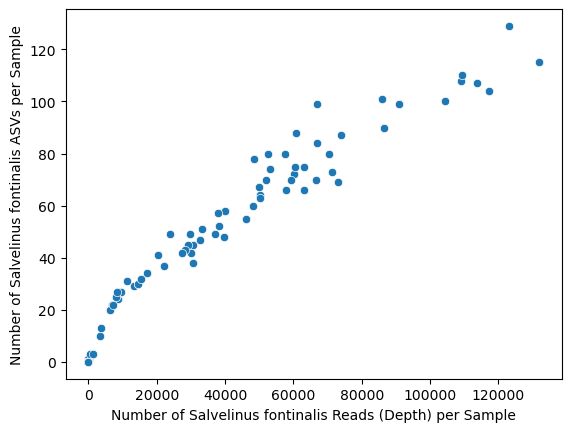

In [54]:
sns.scatterplot(data = depths, x = 0, y = 1)
plt.ylabel("Number of Salvelinus fontinalis ASVs per Sample")
plt.xlabel("Number of Salvelinus fontinalis Reads (Depth) per Sample")

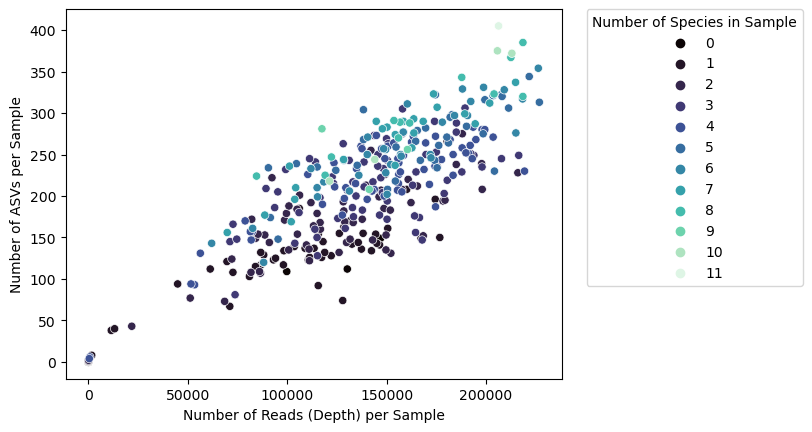

In [88]:
g = sns.scatterplot(data = depths.sort_values("Number of Species"), x = "nreads", y = "nasvs", 
                hue = "Number of Species", palette = "mako", legend = "full")
plt.ylabel("Number of ASVs per Sample")
plt.xlabel("Number of Reads (Depth) per Sample")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, 
           title = "Number of Species in Sample", alignment='center')

In [29]:
depths

,0,1
0,69819,156
0,103839,143
0,187818,343
0,129845,144
0,56292,131
...,...,...
0,175432,307
0,211392,306
0,147491,257
0,81871,147


In [25]:
pd.DataFrame([["ASS","TIDDIES"], ["ASS", "TIDDIES"]])

,0,1
0,ASS,TIDDIES
1,ASS,TIDDIES


In [22]:
asvs.columns[2:-4]

Index(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=387)

In [27]:
asvs["1"].sum()

69819

In [136]:
scale = pd.read_csv("../SCALEPILOT_MyFish_ASVbySample_Chordata98_2Feb24.csv")

/tmp/ipykernel_3041858/1103525307.py:1: DtypeWarning: Columns (398) have mixed types. Specify dtype option on import or set low_memory=False.
  scale = pd.read_csv("../SCALEPILOT_MyFish_ASVbySample_Chordata98_2Feb24.csv")


In [138]:
scale = scale[["ASV"] + [str(i) for i in list(range(140,156))] + ["Genus", "Unnamed: 395"]]

In [140]:
scale["nonzero"] = scale[[str(i) for i in list(range(140,156))]].astype(bool).sum(axis=1)

/tmp/ipykernel_3041858/1441304225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scale["nonzero"] = scale[[str(i) for i in list(range(140,156))]].astype(bool).sum(axis=1)


In [142]:
scale = scale[scale["nonzero"] > 0]

In [144]:
scale["Unnamed: 395"].unique()

array(['Lepomis gibbosus', 'Catostomus commersonii',
       'Salvelinus fontinalis', 'Micropterus dolomieu',
       'Semotilus atromaculatus', 'AMBIGUOUS', 'Salvelinus namaycush',
       'Umbra limi', 'Ameiurus nebulosus', 'Chrosomus eos',
       'Osmerus mordax', 'Eurycea bislineata', 'Homo sapiens'],
      dtype=object)

In [145]:
scale["Genus"].unique()

array(['Lepomis', 'Catostomus', 'Salvelinus', 'Micropterus', 'Semotilus',
       'Umbra', 'Ameiurus', 'Chrosomus', 'AMBIGUOUS', 'Osmerus',
       'Eurycea', 'Homo', 'Cottus'], dtype=object)

In [ ]:
Lepomis gibbosus
Salvelinus fontinalis
Catostomus commersonii
Semotilus atromaculatus
Notophthalmus viridescens
Ameiurus nebulosus
Micropterus dolomieu
Salvelinus namaycush
Umbra limi
Chrosomus eos
Osmerus mordax
Eurycea bislineata
Cottus cognatus

In [147]:
with open('../unassigned.fasta', 'w') as f:
    for line in range(len(asvs["ASV"][asvs["species"] == "ASS"].tolist())):
        f.write(">" + str(line) + "\n")
        f.write(asvs["ASV"][asvs["species"] == "ASS"].tolist()[line] + "\n")

In [146]:
asvs[asvs["species"] == "ASS"]

,Unnamed: 0,ASV,1,10,100,101,102,103,104,105,...,95,96,97,98,99,PB1,PB2,CountsAcross,species,ASV_length
38,39,CACCGATGATATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,557,0,2308,3569,867,1863,0,0,...,1643,2432,2545,901,1368,0,0,186340,ASS,170
62,63,CACCGAGGATATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,0,0,1256,1650,0,629,0,0,...,1004,1719,1669,0,0,0,0,117978,ASS,170
237,238,CACCGCTGATATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,897,955,0,0,0,0,39363,ASS,170
329,330,CACAGCGGGGATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,0,0,222,432,0,0,0,0,...,269,576,495,0,0,0,0,27918,ASS,170
331,332,GACAGCGGGGATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,0,0,376,798,0,612,0,0,...,0,327,905,445,0,0,0,27593,ASS,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,6642,CACATCGGTTAGACGAGAGGCCCTAGTTGATATTACAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,71,ASS,173
6647,6648,CCCCGCGGGATTACGAGAGGCCCAAGTTGTTTGACATCGGCGGAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,70,ASS,170
6720,6721,CACATAGCTTATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,60,ASS,171
6724,6725,CCCCGCGTGATTACGAGAGGCCCAAGTTGTTTGACATCGGCGGAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,59,ASS,170


In [164]:
asvs[asvs["species"] == "Aphelocoma coerulescens"]

,Unnamed: 0,ASV,1,10,100,101,102,103,104,105,...,95,96,97,98,99,PB1,PB2,CountsAcross,species,ASV_length
6766,6767,CACATCGGTCATACAGGAGACCCAAATCAACATTATAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,51,Aphelocoma coerulescens,181
6768,6769,CACAGCGGTCAGACAGGAGACCCAAATCAACATTATAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,51,Aphelocoma coerulescens,181


In [163]:
asvs

,Unnamed: 0,ASV,1,10,100,101,102,103,104,105,...,95,96,97,98,99,PB1,PB2,CountsAcross,species,ASV_length
0,1,CACAGAGCTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,664,4835,2903,0,983,1628,0,4376,...,8646,4690,186,125,2393,0,0,1331155,Lepomis,167
1,2,CACATCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,706,3354,2117,0,884,1148,0,3224,...,5212,3188,0,0,1659,0,0,901679,Lepomis gibbosus,167
2,3,CACAGAGCTTATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,898,0,6827,8391,822,2968,0,0,...,5241,8813,8481,1348,1366,0,0,720375,Perca flavescens,170
3,4,CACAGCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,0,2133,1497,0,0,523,0,2220,...,4346,2664,0,0,995,0,0,612966,Lepomis,167
4,5,CACAGAGCTTATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAA...,2064,0,5155,0,978,1097,0,0,...,2016,6996,0,1621,1522,0,0,586667,Micropterus,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7004,7005,CACAGAGCTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Lepomis,169
7005,7006,CACATCGGTTATACGAGAGGCCCTAGTTGATAAACACGGCGTAAAG...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Catostomus commersonii,172
7006,7007,CACATCGGTTAAACGAGAGGCCCCAGTTAATAATACACGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Notemigonus crysoleucas,175
7007,7008,CACAGCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Lepomis,167


In [167]:
asvs

,Unnamed: 0,ASV,1,10,100,101,102,103,104,105,...,95,96,97,98,99,PB1,PB2,CountsAcross,species,ASV_length
0,1,CACAGAGCTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,664,4835,2903,0,983,1628,0,4376,...,8646,4690,186,125,2393,0,0,1331155,Lepomis,167
1,2,CACATCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,706,3354,2117,0,884,1148,0,3224,...,5212,3188,0,0,1659,0,0,901679,Lepomis gibbosus,167
2,3,CACAGAGCTTATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAA...,898,0,6827,8391,822,2968,0,0,...,5241,8813,8481,1348,1366,0,0,720375,Perca flavescens,170
3,4,CACAGCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,0,2133,1497,0,0,523,0,2220,...,4346,2664,0,0,995,0,0,612966,Lepomis,167
4,5,CACAGAGCTTATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAA...,2064,0,5155,0,978,1097,0,0,...,2016,6996,0,1621,1522,0,0,586667,Micropterus,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7004,7005,CACAGAGCTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Lepomis,169
7005,7006,CACATCGGTTATACGAGAGGCCCTAGTTGATAAACACGGCGTAAAG...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Catostomus commersonii,172
7006,7007,CACATCGGTTAAACGAGAGGCCCCAGTTAATAATACACGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Notemigonus crysoleucas,175
7007,7008,CACAGCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,Lepomis,167


In [169]:
asvs[[str(i) for i in list(range(191,206))] + ["species"]]

,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,species
0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lepomis
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lepomis gibbosus
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Perca flavescens
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lepomis
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Micropterus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lepomis
7005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Catostomus commersonii
7006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Notemigonus crysoleucas
7007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lepomis


In [170]:
lml = asvs[["ASV"] + [str(i) for i in list(range(191,206))] + ["CountsAcross", "species"]]

In [171]:
lml["nonzero"] = lml[[str(i) for i in list(range(191,206))]].astype(bool).sum(axis=1)

/tmp/ipykernel_3041858/4123897475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lml["nonzero"] = lml[[str(i) for i in list(range(191,206))]].astype(bool).sum(axis=1)


In [172]:
lml = lml[lml["nonzero"] != 0]

In [ ]:
Lepomis gibbosus
Salvelinus fontinalis
Catostomus commersonii
Semotilus atromaculatus
Notophthalmus viridescens
Ameiurus nebulosus
Micropterus dolomieu
Salvelinus namaycush
Umbra limi
Chrosomus eos
Osmerus mordax
Eurycea bislineata
Cottus cognatus

In [173]:
lml.species.unique()

array(['Lepomis', 'Semotilus atromaculatus', 'Notophthalmus viridescens',
       'Chrosomus eos', 'ASS'], dtype=object)

In [180]:
asvs["Unnamed: 0"][asvs["species"] == "Oncorhynchus"].tolist()

[2385, 3394, 3565, 5218, 5543, 5866, 5987, 6003, 6068, 6087]

In [183]:
hits[hits[0].isin(asvs["Unnamed: 0"][asvs["species"] == "Oncorhynchus"].tolist())].sort_values(5)

,0,tax_id,2,3,4,5,6,7,8,9,...,11,12,13,superkingdom,phylum,class,order,family,genus,species
543652,6068,335690,255,6068,MW300344.1,94.083,169,8,2,3,...,316,483,9.550000e-64,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus clarkii
543668,6068,8019,255,6068,MH003640.1,94.083,169,8,2,3,...,316,483,9.550000e-64,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus kisutch
543650,6068,74940,255,6068,ON005616.1,94.083,169,8,2,3,...,316,483,9.550000e-64,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus tshawytscha
543651,6068,74940,255,6068,OL404930.1,94.083,169,8,2,3,...,316,483,9.550000e-64,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus tshawytscha
543653,6068,8019,255,6068,OQ846517.1,94.083,169,8,2,3,...,3,170,9.550000e-64,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus kisutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210989,2385,8022,300,2385,OQ846551.1,99.394,165,1,0,6,...,6,170,4.350000e-77,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss
210990,2385,857569,300,2385,OK040162.1,99.394,165,1,0,6,...,319,483,4.350000e-77,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss
210991,2385,8022,300,2385,MT667254.1,99.394,165,1,0,6,...,319,483,4.350000e-77,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss
210978,2385,2978582,300,2385,OK623679.1,99.394,165,1,0,6,...,319,483,4.350000e-77,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss


In [108]:
with open('../test.fasta', 'w') as f:
    for line in range(len(asvs["ASV"][asvs["species"].str.contains("Salvelinus fontinalis")].tolist())):
        f.write(">" + str(line) + "\n")
        f.write(asvs["ASV"][asvs["species"].str.contains("Salvelinus fontinalis")].tolist()[line] + "\n")

In [107]:
!rm ../test.fasta

In [64]:
asvs["ASV"][asvs["species"].str.contains("Salvelinus fontinalis")].tolist()

['AGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGACGTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',
 'AGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGAGGTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',
 'AGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGTCCTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',
 'AGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGTGGTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',
 'AGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGTCGTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',
 'AGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGTGCTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',
 'AGAGGCCCTAGTTGATAAATACCGGCGTAAAGACAGGTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAAT',

In [27]:
asvs[asvs["species"]=="Prosopium cylindraceum"]

,Unnamed: 0,ASV,1,10,100,101,102,103,104,105,...,94,95,96,97,98,99,PB1,PB2,CountsAcross,species
726,727,CACCGCGGTTATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3903,Prosopium cylindraceum
856,857,CACCGAGGTTATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3109,Prosopium cylindraceum
1520,1521,CAGGGCGGTTAGCCGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1041,Prosopium cylindraceum
1709,1710,CACCGAGGTTAGACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,810,Prosopium cylindraceum
1726,1727,CACATCGGTGATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,785,Prosopium cylindraceum
1756,1757,CAGCGAGGTTAGCCGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,739,Prosopium cylindraceum
2023,2024,CACCGCGGTTATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,456,Prosopium cylindraceum
2067,2068,CACCGAGGTTATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,416,Prosopium cylindraceum
2222,2223,CACCGCGGTTATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,287,Prosopium cylindraceum
2245,2246,CACCGAGGTTATACGAGAGGCCCAAGTTGATAACTACCGGCGTAAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,273,Prosopium cylindraceum


In [148]:
asvs.species.unique()

array(['Lepomis', 'Lepomis gibbosus', 'Micropterus', 'Perca flavescens',
       'Salvelinus fontinalis', 'Catostomus commersonii',
       'Semotilus atromaculatus', 'Umbra limi',
       'Notophthalmus viridescens', 'Notemigonus crysoleucas',
       'Micropterus dolomieu', 'Ameiurus nebulosus', nan,
       'Chrosomus neogaeus', 'Ambloplites rupestris',
       'Salvelinus namaycush', 'Prosopium cylindraceum', 'Umbra',
       'Chrosomus eos', 'Rhinichthys atratulus', 'Pimephales notatus',
       'Lepomis macrochirus', 'Ameiurus', 'Osmerus mordax',
       'Couesius plumbeus', 'Pimephales', 'Hypophthalmichthys nobilis',
       'Cottus', 'Fundulus diaphanus', 'Luxilus', 'Perca',
       'Catostomus catostomus', 'Coregonus', 'Salmo salar',
       'Mylopharyngodon piceus', 'Bos', 'Noturus insignis', 'Erimystax',
       'Lateolabrax maculatus', 'Eurycea bislineata', 'Cottus cognatus',
       'Sus scrofa', 'Sander vitreus', 'Ameiurus melas', 'Carassius',
       'Hypophthalmichthys', 'Catostomus',

In [151]:
hits[hits[0] == 4]

,0,tax_id,2,3,4,5,6,7,8,9,...,11,12,13,superkingdom,phylum,class,order,family,genus,species
300,4,27706,287,4,OM736837.1,98.758,161,2,0,9,...,325,485,3.360000e-73,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Micropterus,Micropterus salmoides
301,4,489037,287,4,MH301074.1,98.758,161,2,0,9,...,325,485,3.360000e-73,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Micropterus,Micropterus salmoides
302,4,27706,287,4,LC474183.1,98.758,161,2,0,9,...,9,169,3.360000e-73,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Micropterus,Micropterus salmoides
303,4,27706,287,4,PP620822.1,98.758,161,2,0,9,...,16,176,3.360000e-73,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Micropterus,Micropterus salmoides
304,4,27706,287,4,OQ793737.1,98.758,161,2,0,9,...,253,413,3.360000e-73,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Micropterus,Micropterus salmoides
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,4,201697,200,4,OQ198777.1,89.308,159,17,0,9,...,30,188,4.510000e-47,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Pomoxis,Pomoxis annularis
396,4,201697,200,4,OQ198757.1,89.308,159,17,0,9,...,30,188,4.510000e-47,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Pomoxis,Pomoxis annularis
397,4,201697,200,4,OQ198759.1,89.308,159,17,0,9,...,30,188,4.510000e-47,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Pomoxis,Pomoxis annularis
398,4,109273,198,4,KM282394.1,90.132,152,15,0,16,...,1,152,1.620000e-46,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Centrarchidae,Ambloplites,Ambloplites rupestris


In [150]:
hits[hits["genus"] == "Siniperca"]

,0,tax_id,2,3,4,5,6,7,8,9,...,11,12,13,superkingdom,phylum,class,order,family,genus,species
378,4,228252,206,4,MF966982.1,90.385,156,15,0,9,...,171,326,9.680000e-49,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
380,4,228252,206,4,MF966978.1,90.385,156,15,0,9,...,171,326,9.680000e-49,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
383,4,228252,206,4,MF966980.1,90.385,156,15,0,9,...,171,326,9.680000e-49,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
385,4,228252,200,4,MF966983.1,89.744,156,16,0,9,...,171,326,4.510000e-47,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
389,4,228252,200,4,MF966984.1,89.744,156,16,0,9,...,171,326,4.510000e-47,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815610,8945,228252,163,8945,MF966983.1,85.714,154,22,0,11,...,173,326,5.910000e-36,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
815614,8945,228252,163,8945,MF966984.1,85.714,154,22,0,11,...,173,326,5.910000e-36,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
815615,8945,228252,163,8945,MF966979.1,85.714,154,22,0,11,...,173,326,5.910000e-36,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri
815616,8945,228252,163,8945,MF966981.1,85.714,154,22,0,11,...,173,326,5.910000e-36,Eukaryota,Chordata,Actinopteri,Centrarchiformes,Sinipercidae,Siniperca,Siniperca scherzeri


In [95]:
refseq

,0,tax_id,2,3,4,5,6,7,8,9,...,11,12,13,superkingdom,phylum,class,order,family,genus,species


In [61]:
(hits[hits[4].str.contains("^NC")][~hits["tax_id"].isin([2557536,8034])]
 [hits[0].isin(set(hits[0][hits["genus"] == "Salvelinus"].tolist()))].head(60))

/tmp/ipykernel_1365542/411969318.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (hits[hits[4].str.contains("^NC")][~hits["tax_id"].isin([2557536,8034])]


,0,tax_id,2,3,4,5,6,7,8,9,...,11,12,13,superkingdom,phylum,class,order,family,genus,species
620,7,8038,285,7,NC_000860.1,98.750,160,2,0,9,...,1286,1445,1.200000e-72,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus fontinalis
624,7,230553,268,7,NC_046708.1,96.875,160,5,0,9,...,322,481,1.210000e-67,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus levanidovi
631,7,85065,263,7,NC_068270.1,96.250,160,6,0,9,...,322,481,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus malma
666,7,83385,263,7,NC_028018.1,96.250,160,6,0,9,...,1316,1475,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus albus
669,7,152107,263,7,NC_046707.1,96.250,160,6,0,9,...,322,481,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus elgyticus
680,7,565044,263,7,NC_029877.1,96.250,160,6,0,9,...,1317,1476,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus kuznetzovi
681,7,8037,263,7,NC_066907.1,96.250,160,6,0,9,...,322,481,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus confluentus
693,7,152113,263,7,NC_046710.1,96.250,160,6,0,9,...,322,481,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus taranetzi
695,7,152106,263,7,NC_046706.1,96.250,160,6,0,9,...,322,481,5.620000e-66,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus boganidae
1220,13,8038,296,13,NC_000860.1,99.387,163,1,0,6,...,1283,1445,5.540000e-76,Eukaryota,Chordata,Actinopteri,Salmoniformes,Salmonidae,Salvelinus,Salvelinus fontinalis


In [56]:
set(hits[0][hits["genus"] == "Salvelinus"].tolist())

{7,
 13,
 25,
 61,
 84,
 98,
 99,
 105,
 117,
 118,
 120,
 133,
 140,
 147,
 155,
 178,
 179,
 204,
 209,
 245,
 257,
 262,
 267,
 275,
 286,
 288,
 292,
 305,
 319,
 330,
 334,
 392,
 399,
 411,
 421,
 448,
 458,
 494,
 499,
 505,
 518,
 530,
 532,
 533,
 536,
 550,
 554,
 557,
 564,
 565,
 571,
 584,
 587,
 612,
 622,
 630,
 652,
 657,
 660,
 686,
 691,
 724,
 756,
 792,
 818,
 864,
 878,
 880,
 887,
 888,
 896,
 907,
 908,
 916,
 924,
 927,
 936,
 937,
 959,
 990,
 993,
 999,
 1001,
 1018,
 1042,
 1049,
 1068,
 1076,
 1077,
 1082,
 1089,
 1098,
 1119,
 1120,
 1122,
 1143,
 1160,
 1165,
 1168,
 1170,
 1174,
 1183,
 1187,
 1191,
 1206,
 1217,
 1231,
 1232,
 1237,
 1241,
 1279,
 1304,
 1310,
 1319,
 1332,
 1347,
 1360,
 1391,
 1393,
 1400,
 1406,
 1422,
 1423,
 1430,
 1438,
 1450,
 1453,
 1459,
 1474,
 1480,
 1492,
 1508,
 1531,
 1547,
 1565,
 1572,
 1586,
 1599,
 1635,
 1647,
 1655,
 1661,
 1675,
 1681,
 1711,
 1712,
 1734,
 1765,
 1775,
 1782,
 1795,
 1803,
 1812,
 1828,
 1833,
 1859

In [167]:
luxilus = asvs[asvs["species"] == "Chrosomus eos"]

In [168]:
luxilus = luxilus.loc[:, (luxilus != 0).any(axis=0)]

In [169]:
luxilus

,Unnamed: 0,ASV,13,14,145,146,154,155,160,161,...,73,75,80,81,83,84,86,91,96,species
184,185,CACATCGGTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,739,0,0,0,0,0,...,0,0,0,0,0,0,0,261,2,Chrosomus eos
197,198,CACAGAGCTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,827,0,0,0,0,0,...,0,0,0,0,0,0,0,253,0,Chrosomus eos
213,214,CACATCGGTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,0,0,323,676,3204,2807,...,0,0,0,0,0,0,0,0,0,Chrosomus eos
222,223,CACAGAGCTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,1,0,5,378,801,3166,2689,...,1,0,0,0,0,0,0,0,0,Chrosomus eos
288,289,CACATCGGTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,145,794,236,243,205,0,0,0,Chrosomus eos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,7852,CTCAGAGCTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chrosomus eos
8026,8027,CTGCGCGGTTACACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chrosomus eos
8035,8036,CAAAGCCGTTAAACGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chrosomus eos
8036,8037,CAGGGCGGTTACCCGAGAGGCCCTAGTTAACAATACAACGGCGTAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chrosomus eos


In [171]:
luxilus.astype(bool).sum(axis=0).head(60)

Unnamed: 0    297
ASV           297
13              1
14              2
145            62
146             3
154            34
155            36
160            46
161            49
163            46
164            45
165             4
175           108
181            38
182            42
184            42
185            44
186             9
187            46
188           125
191           135
192           137
193           124
194           131
195           128
196           135
197           124
198           143
199           134
200           122
201           128
202           141
203           127
204           130
205           132
206           137
239            28
291             2
294             1
297             1
299             1
355            40
358            66
359            48
360            38
362            51
363            32
365            41
369            48
370             1
45              1
53             79
56              7
71             13
72        